# Segmentation

_Tiffany Wang 260684152_

### 1.1 K-means clustering and Expectation Maximization

In [4]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import math
from skimage import data, segmentation
from skimage.future import graph
from sklearn.cluster import MeanShift

In [25]:
def plot_figs(imgs, titles=None, max_col=4):
    """
    Plots list of images in a grid. 
    -----
    args imgs: list of images.
    args titles: list of titles, defaults to None.
    args max_col: number of column in the grid, defaults to 4.
    -----
    return: None.
    """
    n = len(imgs)
    
    # Each plot can hold up to 8 images.
    rows_per_set = 8 // max_col 
    fig_per_set = rows_per_set * max_col
    sets = math.ceil(n / fig_per_set)
    
    for s in range(sets):
        # starting index of your set
        start = s * fig_per_set
        
        # compute the number of images and rows in the current set 
        subset_len = min(start+fig_per_set, n) - start
        nb_rows = math.ceil(subset_len / max_col)
        
        # set subplot map 
        subplot = "{}{}".format(nb_rows, max_col)
        plt.figure(figsize=(20, 4 * nb_rows))
        for i in range(subset_len):
            plt.subplot(int("{}{}".format(subplot, i+1)))
            if titles is not None: 
                plt.title(titles[start + i])
            else:
                plt.title(str(start + i + 1))
            plt.axis('off')
            plt.imshow(imgs[start + i].astype(np.uint8))
    plt.show()

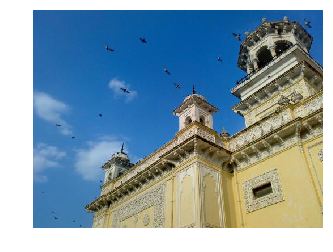

In [26]:
# Read 'home.jpg' picture in RGB.
home = cv2.imread('home.jpg')
home = cv2.cvtColor(home, cv2.COLOR_BGR2RGB)
plt.imshow(home), plt.axis('off')
plt.show()

###### Implement K-means clustering algorithm using only the numpy library. You can use opencv and matplotlib libraries only to read and display images but not for clustering. Apply k-means to the provided image with K=2 and K=3. Display the resulting segmented images for 10 iterations in both cases.

In [27]:
def k_means(img, k, iter=10):
    """
    Performs image segmentation, and plots training evolution at each iteration.
    -----
    args img: the image.
    args k: number of clusters.
    args iter: number of iterations, defaults to 10.
    -----
    return: None.
    """
    h, w, ch = img.shape
    img = img.astype(np.float64)
    
    # Randomly select the k cluster centers. 
    centers = np.random.random_sample((k, ch)) * 255.0
    evol = []
    for it in range(iter):
        # Compute distance between each pixel and cluster center.
        dists = np.array([img - c for c in centers])
        dists = np.linalg.norm(dists, axis=-1)
        
        # Assign pixel to cluster with closest center. 
        clusters = np.argmin(dists, axis=0)
        evol.append(clusters)
        
        # Compute new cluster centers.
        new_c = np.empty(shape=(k,ch))
        for c in range(k):
            np.mean(img[clusters == c], axis=0, out=new_c[c])
        centers = new_c
    
    # Plot evolution.
    plot_figs(evol, max_col=3)

K-means segmentation with two clusters.

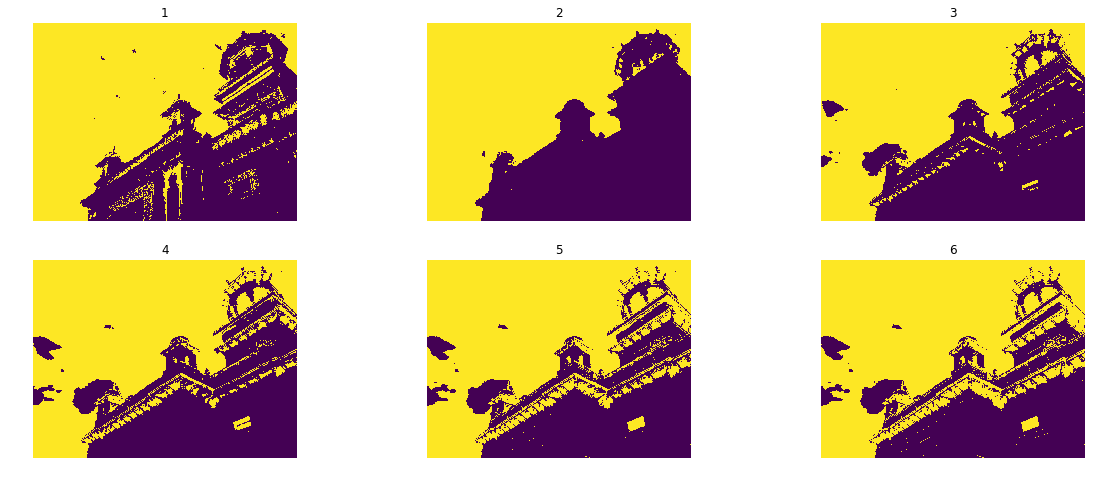

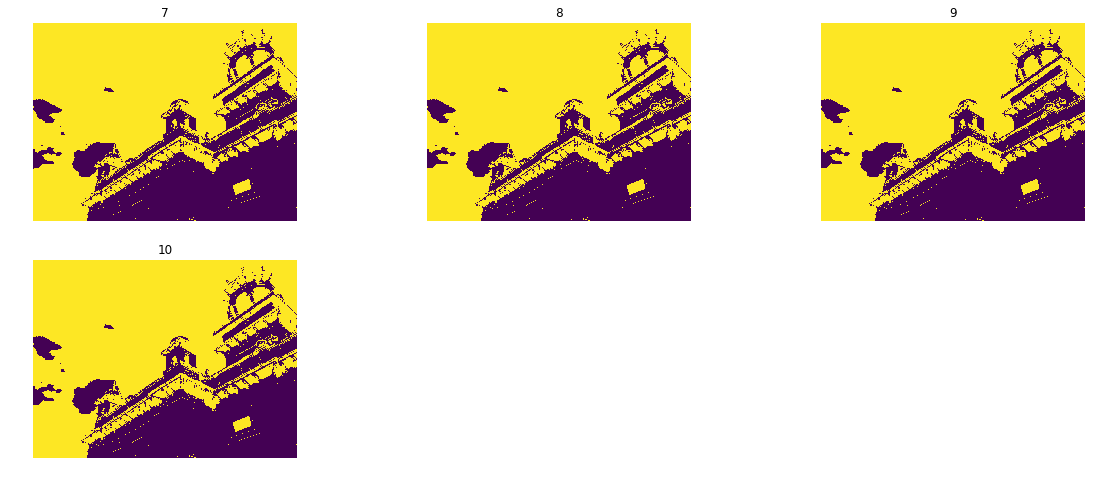

In [28]:
k_means(home, 2)

K-means segmentation with three clusters.

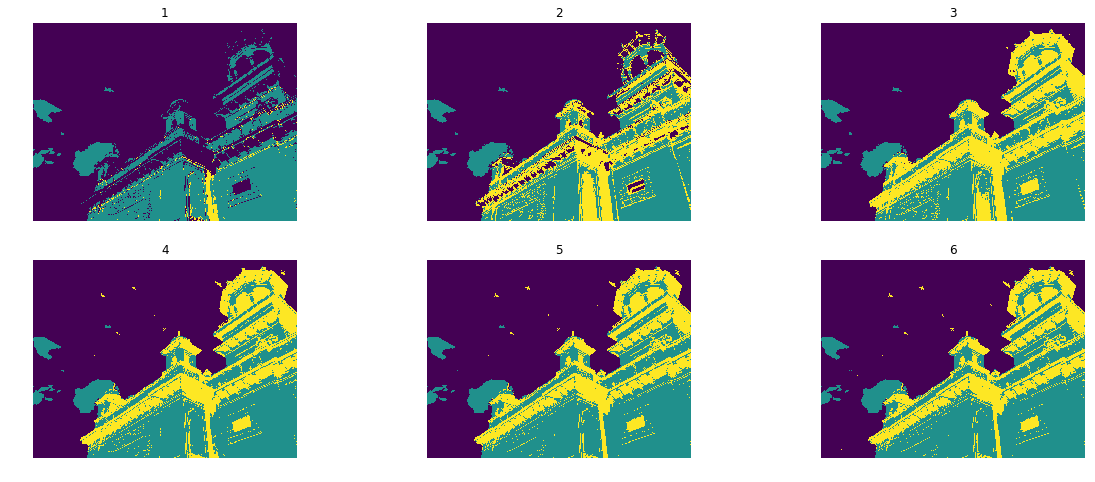

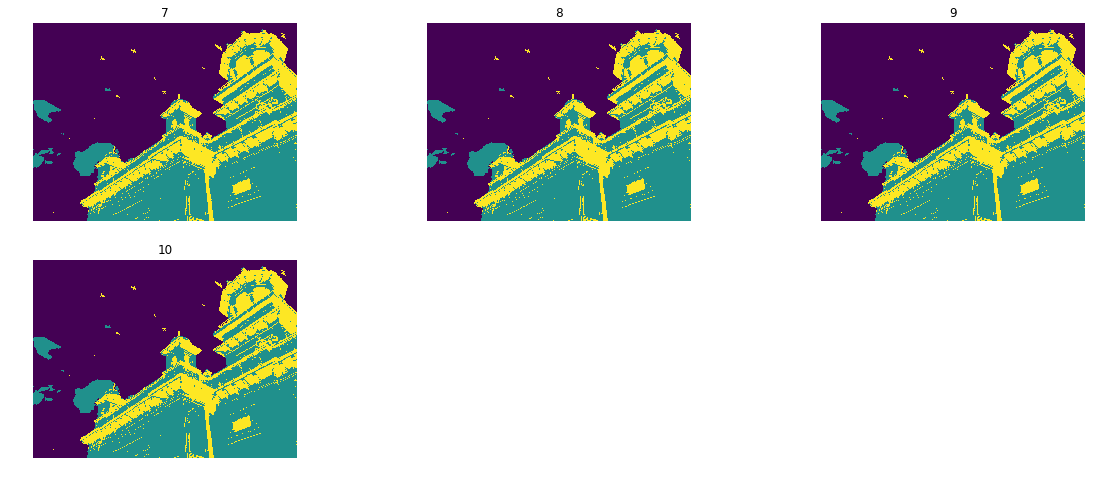

In [21]:
k_means(home, 3)

 ###### Implement the EM algorithm using only the numpy library. You can use opencv and matplotlib libraries only to read and display images. Apply it to the given image with 2 and 3 Gaussian components. Display the resulting segmented images for 10 iterations in both cases.

In [12]:
def gauss(x, mu, std):
    """
    Compute probability of the association between a sample and a Gaussian Distribution. 
    -----
    args x: the sample. 
    args mu: the mean of the Gaussian distribution. 
    args std: the standard deviation of the Gaussian distribution. 
    -----
    returns: the probability of the association. 
    """
    return np.linalg.norm(math.e**(-0.5 * np.power((x-mu)/std, 2)) / (math.sqrt(2*math.pi) * std), axis=-1)

def em(img, k, iter=10):
    h, w, ch = img.shape
    mus = np.random.random((k, ch)) * 255.0
    probs = np.full((k), (1.0 / k))
    std = np.full((k, ch), (255.0 / k))
    evol = []
    for it in range(iter):
        print("iteration ", it)
        print("mus: \n", mus)
        print("std: \n", std)
        print("probs: \n", probs)
        
        # E-step
        exp = np.empty(shape=(h, w, k))
        for i in range(h):
            for j in range(w): 
                exp[i][j] = gauss(img[i][j], mus, std)
        
        denom = np.sum(exp * probs, axis=-1)
        denom = denom.reshape((h, w, 1))
        exp = exp / denom
        
        #draw clusters
        clusters = np.argmax(exp, axis=-1)
        evol.append(clusters)
        
        #M-step 
        for c in range(k): 
            e = 0
            for i in range(h):
                for j in range(w): 
                    e += exp[i, j, c] * img[i, j]
            mus[c] = e / np.sum(exp[:,:,c])
            curr = img[clusters==c]
            std[c] = np.sqrt(np.var(curr, axis=0))
            probs[c] = np.size(curr) / np.size(img)
            
    plot_figs(evol)

iteration  0
mus: 
 [[181.75451779 171.8652718  113.50177434]
 [199.02780738   8.55015455 160.00869358]]
std: 
 [[127.5 127.5 127.5]
 [127.5 127.5 127.5]]
probs: 
 [0.5 0.5]
iteration  1
mus: 
 [[ 94.1119169  125.30267806 141.21441324]
 [ 88.91422731 122.3325298  141.26727246]]
std: 
 [[65.78520638 38.12064426 44.9389501 ]
 [15.27063231 22.62985905 54.67242979]]
probs: 
 [0.76050313 0.23949687]
iteration  2
mus: 
 [[ 92.75113315 124.65992671 141.39248613]
 [ 88.26577868 121.56752572 140.79345645]]
std: 
 [[86.60914143 52.84223164 41.56942896]
 [41.91327872 22.17471284 53.32109224]]
probs: 
 [0.52519226 0.47480774]
iteration  3
mus: 
 [[ 96.56034219 126.83895049 141.16309977]
 [ 86.81956791 121.00292892 141.31411834]]
std: 
 [[88.97823295 51.70621763 33.65309999]
 [41.72439251 25.04719245 55.57228391]]
probs: 
 [0.42837524 0.57162476]
iteration  4
mus: 
 [[ 99.00477529 128.63207793 141.82373097]
 [ 86.41488265 120.52974383 140.82990368]]
std: 
 [[88.88383962 50.2559106  31.00980345]
 [4

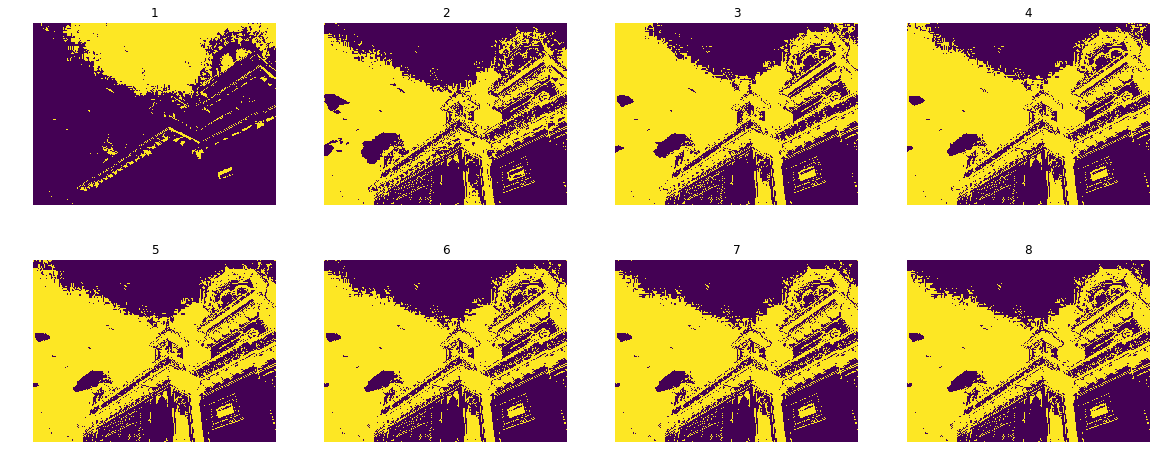

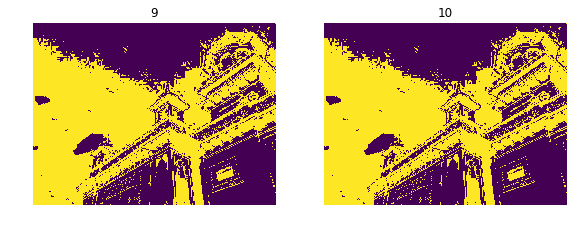

In [14]:
em(home, 2, 10)

iteration  0
mus: 
 [[144.30954167 110.25032194 156.11873736]
 [  0.87402488 128.44522559 175.05481272]
 [210.76686889 145.6690273  227.12524789]]
std: 
 [[85. 85. 85.]
 [85. 85. 85.]
 [85. 85. 85.]]
probs: 
 [0.33333333 0.33333333 0.33333333]
iteration  1
mus: 
 [[ 92.8678687  123.44229262 138.80759261]
 [ 82.65151523 118.91817707 141.63457924]
 [100.67026072 130.22773734 143.67589587]]
std: 
 [[37.9150862  35.57447923 48.07747576]
 [20.69847819 23.15888554 40.58810403]
 [16.33591919  9.45499737 29.67061646]]
probs: 
 [0.31719971 0.51580302 0.16699727]
iteration  2
mus: 
 [[ 91.47569244 121.94134057 137.62952872]
 [ 88.53795329 122.51323076 141.85798162]
 [101.1064699  131.18341801 145.3660693 ]]
std: 
 [[70.47246736 67.38688814 70.22232679]
 [38.23833937 22.2853215  47.05430397]
 [68.13044971 37.93459353 39.05799981]]
probs: 
 [0.09782918 0.38241069 0.51976013]
iteration  3
mus: 
 [[ 92.28135963 121.63274989 135.85024372]
 [ 87.36997616 121.13904354 140.79167512]
 [ 94.88777753 126.3

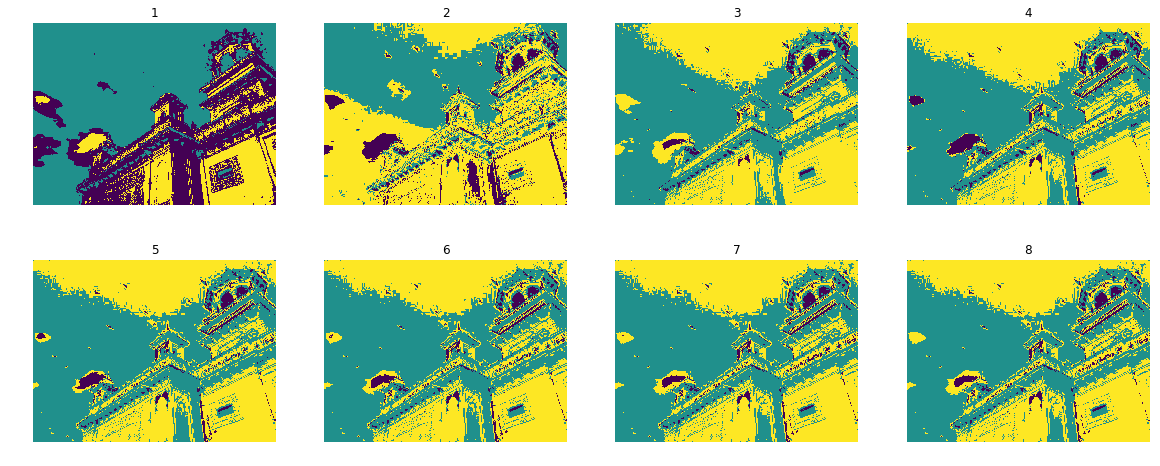

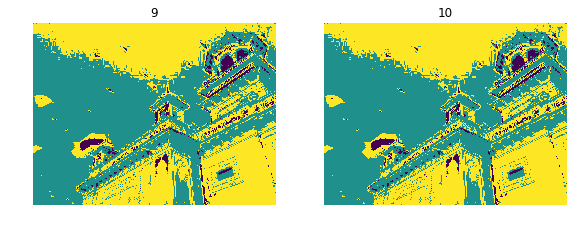

In [15]:
em(home, 3, 10)

###### Under what data distribution conditions would K-means and EM give the same solution, provided similar initializations?

K-means and EM give the same solution when the data are scattered in really defined and separated clustered. This is because there is less overlapping between Gaussian distribution curves, so the data can be better classified with high confidence and probability rate. At the same time, such data distribution defines clear boundaries for each 'neighborhood' in the cases of K-means. 

### 1.2 Normalized graph-cut and Mean-Shift segmentation

###### Segment the given image using normalized graph-cuts. Vary the following parameters (try several values of each parameter): compactness and n segments (slic function), thresh (cut normalized function). Display segmentation results for several parameters and state their effect on the output.

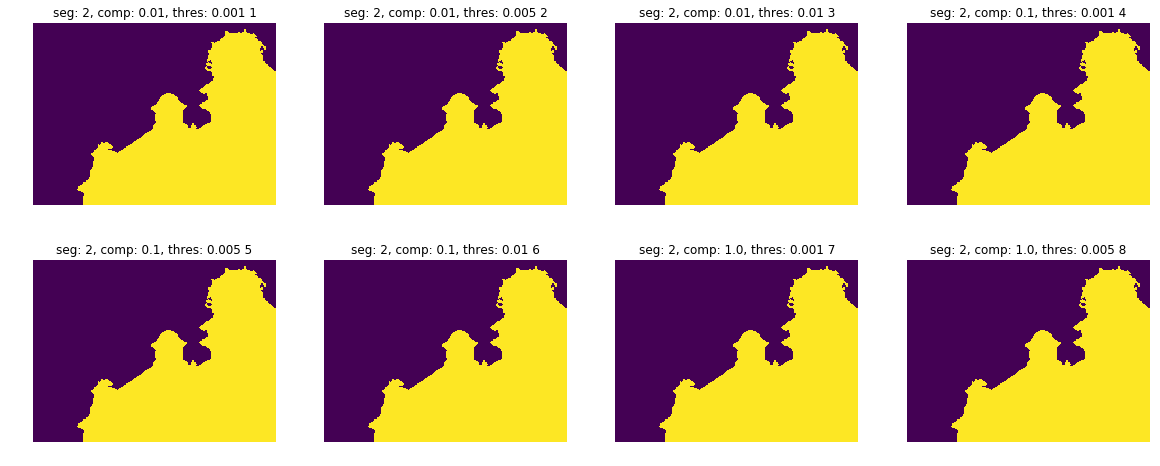

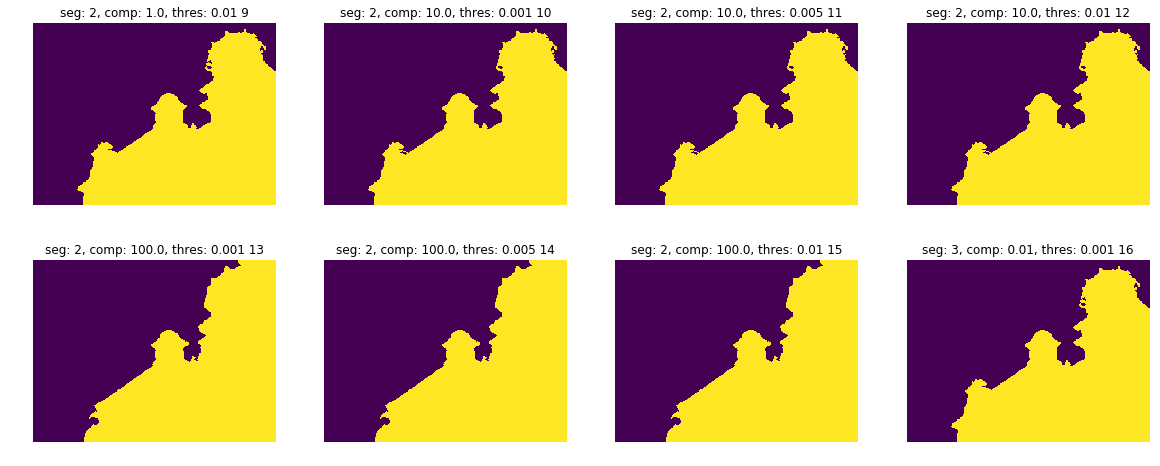

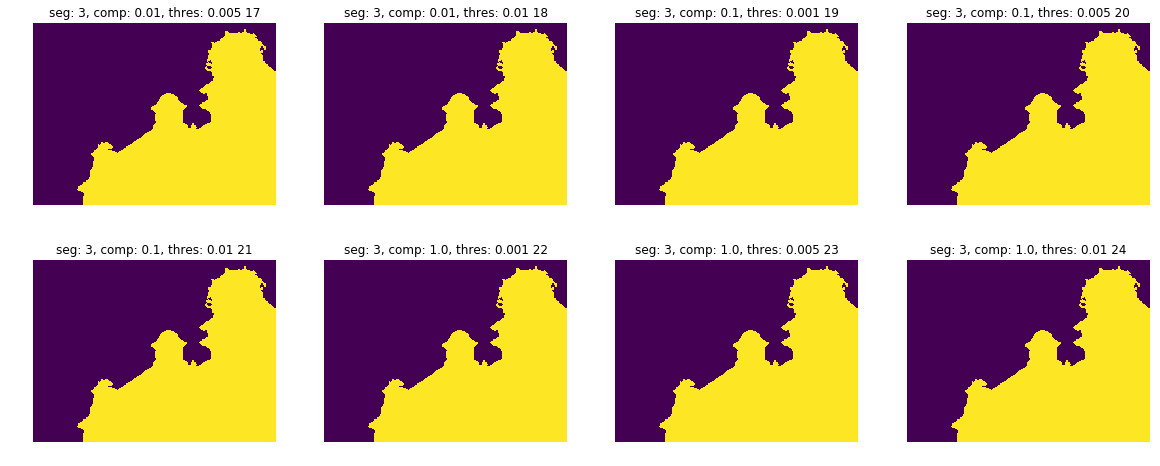

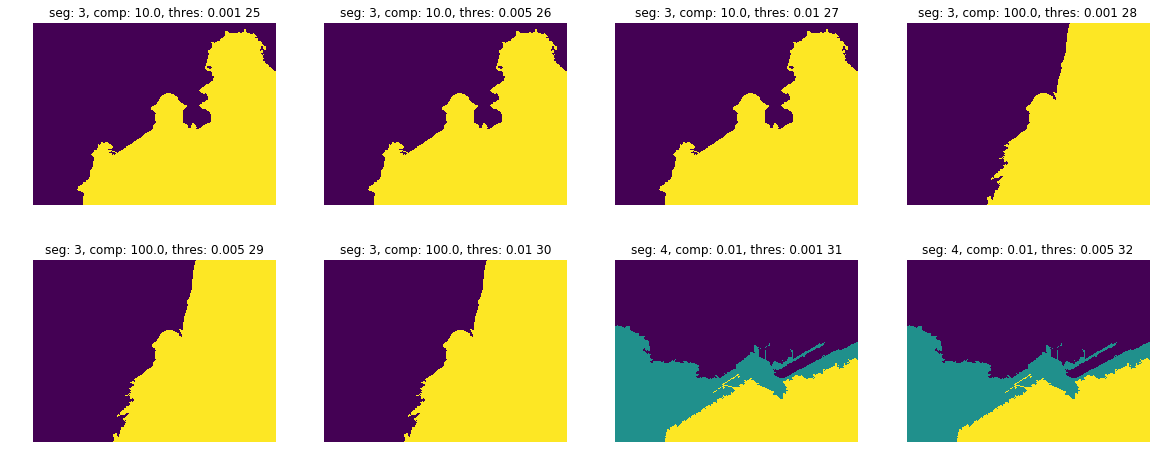

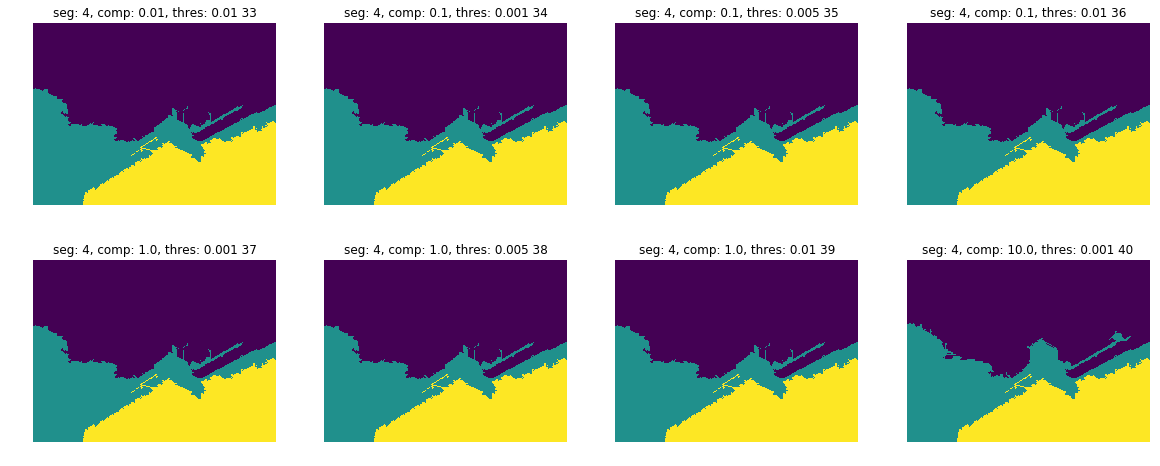

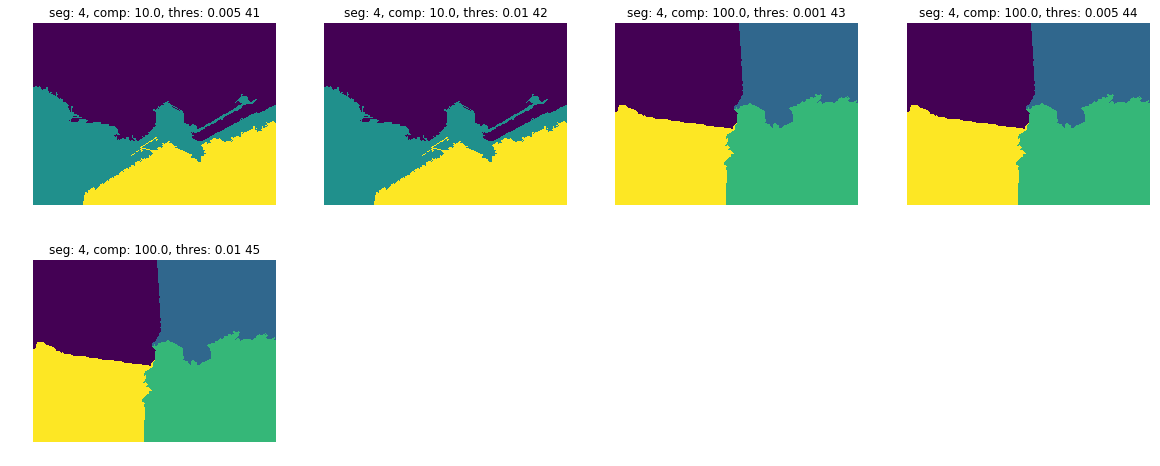

<Figure size 1440x288 with 0 Axes>

<Figure size 1440x288 with 0 Axes>

<Figure size 1440x288 with 0 Axes>

<Figure size 1440x288 with 0 Axes>

<Figure size 1440x288 with 0 Axes>

In [27]:
segments = range(2, 5) #3
compactness = [0.01 * 10 ** (i) for i in range(5)] #5
thresholds = [0.001, 0.005, 0.01] #3

pictures = []
title = []

for seg in segments: 
    for comp in compactness: 
        for thres in thresholds: 
            labels = segmentation.slic(home, n_segments=seg, compactness=comp)
            rag = graph.rag_mean_color(home, labels)
            res = graph.cut_threshold(labels, rag, 10)
            pictures.append(res)
            title.append("seg: {}, comp: {}, thres: {}".format(seg, comp, thres))
plot_figs(pictures, title)

Effect of parameters on the results: 

<ul>
    <li> <b>Compactness </b> </li>
    This parameter determines the color similarity and proximity of the clusters. 
        